In [1]:
import xarray as xr
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from direct_effect_analysis import *
from scipy.stats import f
from sklearn.linear_model import LinearRegression, RidgeCV
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from tqdm import tqdm
from plotnine import ggplot, aes, geom_line, geom_ribbon, scale_x_log10, scale_x_continuous, labs, theme, facet_wrap, ggsave
import seaborn as sns
from scipy.linalg import null_space
from partial_ridge import PartialRidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
anomalies_tas = np.zeros((50, 1669, 648))
dir = '/home/homer/Documents/Teaching/MAIN4/data/TAS'
for i, file in enumerate(os.listdir(dir)):
   data = xr.open_dataset(dir + '/' + file)
   data = data.sel(time=slice('1880-01-01', '2019-02-01'))
   data_coarsen = data.coarsen(lat=4, lon=4, boundary='trim').mean()#
   if i == 0 :
      seasonality = data_coarsen.groupby('time.month').mean()
   anomalies_coarsen = data_coarsen.groupby('time.month') - seasonality
   anomalies_np = anomalies_coarsen['tas'].data
   anomalies_tas[i, :, :] = anomalies_np.reshape(anomalies_np.shape[0], anomalies_np.shape[1]*anomalies_np.shape[2])

response_tas = anomalies_tas.mean(axis=0)

In [3]:
anomalies_psl = np.zeros((50, 1669, 648))
dir = '/home/homer/Documents/Teaching/MAIN4/data/PSL'
for i, file in enumerate(os.listdir(dir)):
   data = xr.open_dataset(dir + '/' + file)
   data = data.sel(time=slice('1880-01-01', '2019-02-01'))
   data_coarsen = data.coarsen(lat=4, lon=4, boundary='trim').mean()#
   if i == 0 :
      seasonality = data_coarsen.groupby('time.month').mean()
   anomalies_coarsen = data_coarsen.groupby('time.month') - seasonality
   anomalies_np = anomalies_coarsen['psl'].data
   anomalies_psl[i, :, :] = anomalies_np.reshape(anomalies_np.shape[0], anomalies_np.shape[1]*anomalies_np.shape[2])

response_psl = anomalies_psl.mean(axis=0)


In [4]:
def power_method(X, Y, Z, n_components = 10, algo='OptiDet', alpha=8e4):
    dea = DirectEffectAnalysis(algo, alpha=alpha)
    W = np.zeros((Y.shape[1], n_components))
    Y_rec = 0
    for i in range(n_components):
        dea.fit(X, Y, Z)
        w = dea.W[:, 0, None]
        w = w/np.linalg.norm(w)
        W[:, i] = dea.W[:, 0]
        Y_dyn_hat1 = Y @ w @ w.T
        Y_rec += Y_dyn_hat1
        Y = Y - Y_dyn_hat1
    return np.array(Y_rec), W

def get_trends(Y):
    coefs_hat = LinearRegression().fit(np.arange(Y.shape[0])[:, None], Y).coef_
    return coefs_hat
    
def gen_data(anomalies_tas, anomalies_psl, member=0):
    tas_array = anomalies_tas[member, :, :]
    psl_array = anomalies_psl[member, :, :]
    Z = tas_array.mean(axis=1)[:, None]
    X = psl_array
    Y = tas_array
    Y_dynamical = Y - response_tas
    return X, Y, Z, Y_dynamical, response_tas

def plot_coefficients(coef_true_list, coef_hat_list, lon, lat):
    lon = np.array(lon)
    lat = np.array(lat)

    fig, axs = plt.subplots(nrows=len(coef_true_list), ncols=2, figsize=(15, 25),
                            subplot_kw={'projection': ccrs.PlateCarree()})

    # Compute separate limits for true and estimated coefficients
    all_coef_true = np.concatenate([coef_true.reshape(-1) for coef_true in coef_true_list])
    all_coef_hat = np.concatenate([coef_hat.reshape(-1) for coef_hat in coef_hat_list])

    vmax_true = np.max(np.abs(all_coef_true))  # Symmetric range around 0
    vmax_hat = np.max(np.abs(all_coef_hat))  # Symmetric range around 0

    vmin_true, vmin_hat = -vmax_true, -vmax_hat  # Centered at 0

    # Define colormaps
    cmap_true = 'BrBG'
    cmap_hat = 'RdBu_r'

    for i in range(len(coef_true_list)):
        coef_true = coef_true_list[i].reshape(18, 36)
        coef_hat = coef_hat_list[i].reshape(18, 36)

        # Compute MSE between normalized trends
        mse_trends = np.round(np.mean(coef_true**2), 7)

        # Left plot (True coefficients)
        ax_true = axs[i, 0]
        ax_true.coastlines()
        ax_true.add_feature(cfeature.BORDERS, linestyle=':')
        ax_true.add_feature(cfeature.LAND, edgecolor='black')
        coef_true_plot = ax_true.pcolormesh(lon, lat, coef_true,
                                            transform=ccrs.PlateCarree(),
                                            cmap=cmap_true, vmin=vmin_true, vmax=vmax_true)
        ax_true.set_title(f' MSE: {mse_trends} (Member {i+1})')

        # Right plot (Estimated coefficients)
        ax_hat = axs[i, 1]
        ax_hat.coastlines()
        ax_hat.add_feature(cfeature.BORDERS, linestyle=':')
        ax_hat.add_feature(cfeature.LAND, edgecolor='black')
        coef_hat_plot = ax_hat.pcolormesh(lon, lat, coef_hat,
                                          transform=ccrs.PlateCarree(),
                                          cmap=cmap_hat, vmin=vmin_hat, vmax=vmax_hat)
        ax_hat.set_title(f'(Member {i+1})')

    # Add separate colorbars for left and right columns
    cbar_ax1 = fig.add_axes([0.1, 0.08, 0.35, 0.02])  # Left colorbar (True coefficients)
    cbar1 = fig.colorbar(coef_true_plot, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Errors')
    
    cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])  # Right colorbar (Estimated coefficients)
    cbar2 = fig.colorbar(coef_hat_plot, cax=cbar_ax2, orientation='horizontal')
    cbar2.set_label('Estimated Trends')

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  
    plt.show()

def plot_coefficients_full(errors_list, coef_hat_list, coef_true_list, lon, lat):
    lon = np.array(lon)
    lat = np.array(lat)

    fig, axs = plt.subplots(nrows=len(coef_true_list), ncols=3, figsize=(20, 25),
                            subplot_kw={'projection': ccrs.PlateCarree()})

    # Compute separate limits for errors, true coefficients, and estimated coefficients
    all_errors = np.concatenate([errors.reshape(-1) for errors in errors_list])
    all_coef_true = np.concatenate([coef_true.reshape(-1) for coef_true in coef_true_list])
    all_coef_hat = np.concatenate([coef_hat.reshape(-1) for coef_hat in coef_hat_list])

    vmax_errors = np.max(np.abs(all_errors))
    vmax_true = np.max(np.abs(all_coef_true))
    vmax_hat = np.max(np.abs(all_coef_hat))

    vmin_errors, vmin_true, vmin_hat = -vmax_errors, -vmax_true, -vmax_hat

    # Define colormaps
    cmap_errors = 'BrBG'
    cmap_true = 'RdBu_r'
    cmap_hat = 'RdBu_r'

    for i in range(len(coef_true_list)):
        errors = errors_list[i].reshape(18, 36)
        coef_hat = coef_hat_list[i].reshape(18, 36)
        coef_true = coef_true_list[i].reshape(18, 36)

        # Compute MSE between normalized trends
        mse_trends = np.round(np.mean(coef_true**2), 8)

        # Left plot (Errors)
        ax_errors = axs[i, 0]
        ax_errors.coastlines()
        ax_errors.add_feature(cfeature.BORDERS, linestyle=':')
        ax_errors.add_feature(cfeature.LAND, edgecolor='black')
        errors_plot = ax_errors.pcolormesh(lon, lat, errors, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap=cmap_errors, vmin=vmin_errors, vmax=vmax_errors)
        ax_errors.set_title(f'Errors (MSE: {mse_trends})', fontsize=18)

        # Middle plot (Estimated coefficients)
        ax_hat = axs[i, 1]
        ax_hat.coastlines()
        ax_hat.add_feature(cfeature.BORDERS, linestyle=':')
        ax_hat.add_feature(cfeature.LAND, edgecolor='black')
        coef_hat_plot = ax_hat.pcolormesh(lon, lat, coef_hat, 
                                          transform=ccrs.PlateCarree(), 
                                          cmap=cmap_hat, vmin=vmin_hat, vmax=vmax_hat)
        ax_hat.set_title(f'Estimated (Member {i+1})', fontsize=18)

        # Right plot (True coefficients)
        ax_true = axs[i, 2]
        ax_true.coastlines()
        ax_true.add_feature(cfeature.BORDERS, linestyle=':')
        ax_true.add_feature(cfeature.LAND, edgecolor='black')
        coef_true_plot = ax_true.pcolormesh(lon, lat, coef_true, 
                                            transform=ccrs.PlateCarree(), 
                                            cmap=cmap_true, vmin=vmin_true, vmax=vmax_true)
        ax_true.set_title(f'True Coeffs ', fontsize=18)

    # Add separate colorbars for each column
    cbar_ax1 = fig.add_axes([0.1, 0.08, 0.25, 0.02])  # Errors
    cbar1 = fig.colorbar(errors_plot, cax=cbar_ax1, orientation='horizontal')
    cbar1.set_label('Errors', fontsize=18)
    cbar1.ax.tick_params(labelsize=16)
    
    cbar_ax2 = fig.add_axes([0.4, 0.08, 0.25, 0.02])  # Estimated coefficients
    cbar2 = fig.colorbar(coef_hat_plot, cax=cbar_ax2, orientation='horizontal')
    cbar2.set_label('Estimated Trends', fontsize=18)
    cbar2.ax.tick_params(labelsize=16)
    
    cbar_ax3 = fig.add_axes([0.7, 0.08, 0.25, 0.02])  # True coefficients
    cbar3 = fig.colorbar(coef_true_plot, cax=cbar_ax3, orientation='horizontal')
    cbar3.set_label('True Coefficients', fontsize=18)
    cbar3.ax.tick_params(labelsize=16)

    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  
    plt.show()




def compute_trend_mse(Y: np.ndarray, Y_hat: np.ndarray) -> float:
    """
    Computes the Mean Squared Error (MSE) between the normalized trends of Y and Y_hat.
    The trend is computed as the slope of a linear fit over time for each spatial point.

    Parameters:
    Y (np.ndarray): True values of shape (time, space)
    Y_hat (np.ndarray): Predicted values of shape (time, space)

    Returns:
    float: MSE between the normalized computed trends of Y and Y_hat
    """
    time_steps, spatial_points = Y.shape
    time = np.arange(time_steps).reshape(-1, 1)  # Time indices as features
    
    trends_Y = np.zeros(spatial_points)
    trends_Y_hat = np.zeros(spatial_points)
    
    for i in range(spatial_points):
        # Fit linear model for Y
        model_Y = LinearRegression().fit(time, Y[:, i])
        trends_Y[i] = model_Y.coef_[0]  # Extract slope
        
        # Fit linear model for Y_hat
        model_Y_hat = LinearRegression().fit(time, Y_hat[:, i])
        trends_Y_hat[i] = model_Y_hat.coef_[0]  # Extract slope
    
    # Normalize trends
    # trends_Y = (trends_Y - np.mean(trends_Y)) / np.std(trends_Y)
    # trends_Y_hat = (trends_Y_hat - np.mean(trends_Y)) / np.std(trends_Y)
    
    # Compute MSE between normalized trends
    mse_trends = mean_squared_error(trends_Y, trends_Y_hat)
    return mse_trends

In [5]:
X, Y, Z, internal, forced = gen_data(anomalies_tas, anomalies_psl, member=0)

In [6]:
X.shape, Y.shape, Z.shape, internal.shape, forced.shape 

((1669, 648), (1669, 648), (1669, 1), (1669, 648), (1669, 648))

In [7]:
from scipy.signal import detrend

n_year = 20 # 20years working great
start = -n_year*12
end = -1


algorithms = {'Detrending':'Detrending', 'Dynamical Adjustment':'Dynamical Adjustment', 'DEA':'DEA'}
R2_internal = {algo:[] for algo in algorithms.keys()}
R2_forced = {algo:[] for algo in algorithms.keys()}
COEFs_internal = {algo:[] for algo in algorithms.keys()}
COEFs_forced = {algo:[] for algo in algorithms.keys()}

coefs_true_internal_list, coefs_true_forced_list = [], []

Y_recs = []

for member in tqdm(range(50)):
    X, Y, Z, internal, forced = gen_data(anomalies_tas, anomalies_psl, member=member)
    X = X - X.mean(axis=0)
    Y = (Y - Y.mean(axis=0))/Y.std(axis=0)
    Z = Z - Z.mean(axis=0)
    internal = (internal - Y.mean(axis=0))/Y.std(axis=0)
    forced = (forced - Y.mean(axis=0))/Y.std(axis=0)

    # Z = np.convolve(Z[:, 0], np.ones(12*5) / (12*5) , mode='same')[:, None]
    coefs_true_internal = get_trends(internal[start:end])
    coefs_true_internal_list.append(coefs_true_internal)

    coefs_true_forcedl = get_trends(forced[start:end])
    coefs_true_forced_list.append(coefs_true_forcedl)

    for algo in algorithms.keys():
        if algo=='Detrending':
            lr = LinearRegression()
            lr.fit(Z, Y)
            Y_rec = Y - lr.predict(Z)
        elif algo=='Dynamical Adjustment':
            X = detrend(X, axis=0)
            lr = RidgeCV(alphas=np.logspace(1, 4, 100))
            lr.fit(X, Y)
            Y_rec = lr.predict(X)
        elif algo == 'DEA' :
            # X = detrend(X, axis=0)
            reg_idx = np.append(np.ones(X.shape[1]), 0)
            lr = PartialRidgeCV(alphas=np.logspace(1, 6, 20), reg_idx=reg_idx, n_cv=5)
            lr.fit(np.hstack((X, Z)), Y)
            B = lr.coef_.T[:, -1, None]
            B_perp = null_space(B.T)
        
            Y_rec = Y @ B_perp @ np.linalg.inv(B_perp.T @ B_perp) @ B_perp.T
            
        
        coefs_hat_internal = get_trends(Y_rec[start:end])
        coefs_hat_forced = get_trends(Y_rec[-start:end])
        r2_score_internal = compute_trend_mse(internal[start:end], Y_rec[start:end])
        r2_score_forced = compute_trend_mse(forced[start:end], Y[start:end] - Y_rec[start:end])
        R2_internal[algo].append(r2_score_internal)
        R2_forced[algo].append(r2_score_forced)
        COEFs_internal[algo].append(coefs_hat_internal)
        COEFs_forced[algo].append(coefs_hat_forced)

100%|██████████| 50/50 [06:51<00:00,  8.23s/it]


In [8]:
# X = detrend(X, axis=0)
reg_idx = np.append(np.ones(X.shape[1]), 0)
lr = PartialRidgeCV(alphas=np.logspace(1, 6, 20), reg_idx=reg_idx, n_cv=5)
lr.fit(np.hstack((X, Z)), Y)
B = lr.coef_.T[:, -1, None]
B_perp = null_space(B.T)

Y_rec_DEA = Y @ B_perp @ np.linalg.inv(B_perp.T @ B_perp) @ B_perp.T


In [9]:
lr = LinearRegression()
lr.fit(Z, Y)
Y_rec_Detrending = Y - lr.predict(Z)

In [10]:
Y_forced_DEA_hat = Y[start:end] - Y_rec_DEA[start:end]
Y_forced_Detrending_hat = Y[start:end] - Y_rec_Detrending[start:end]

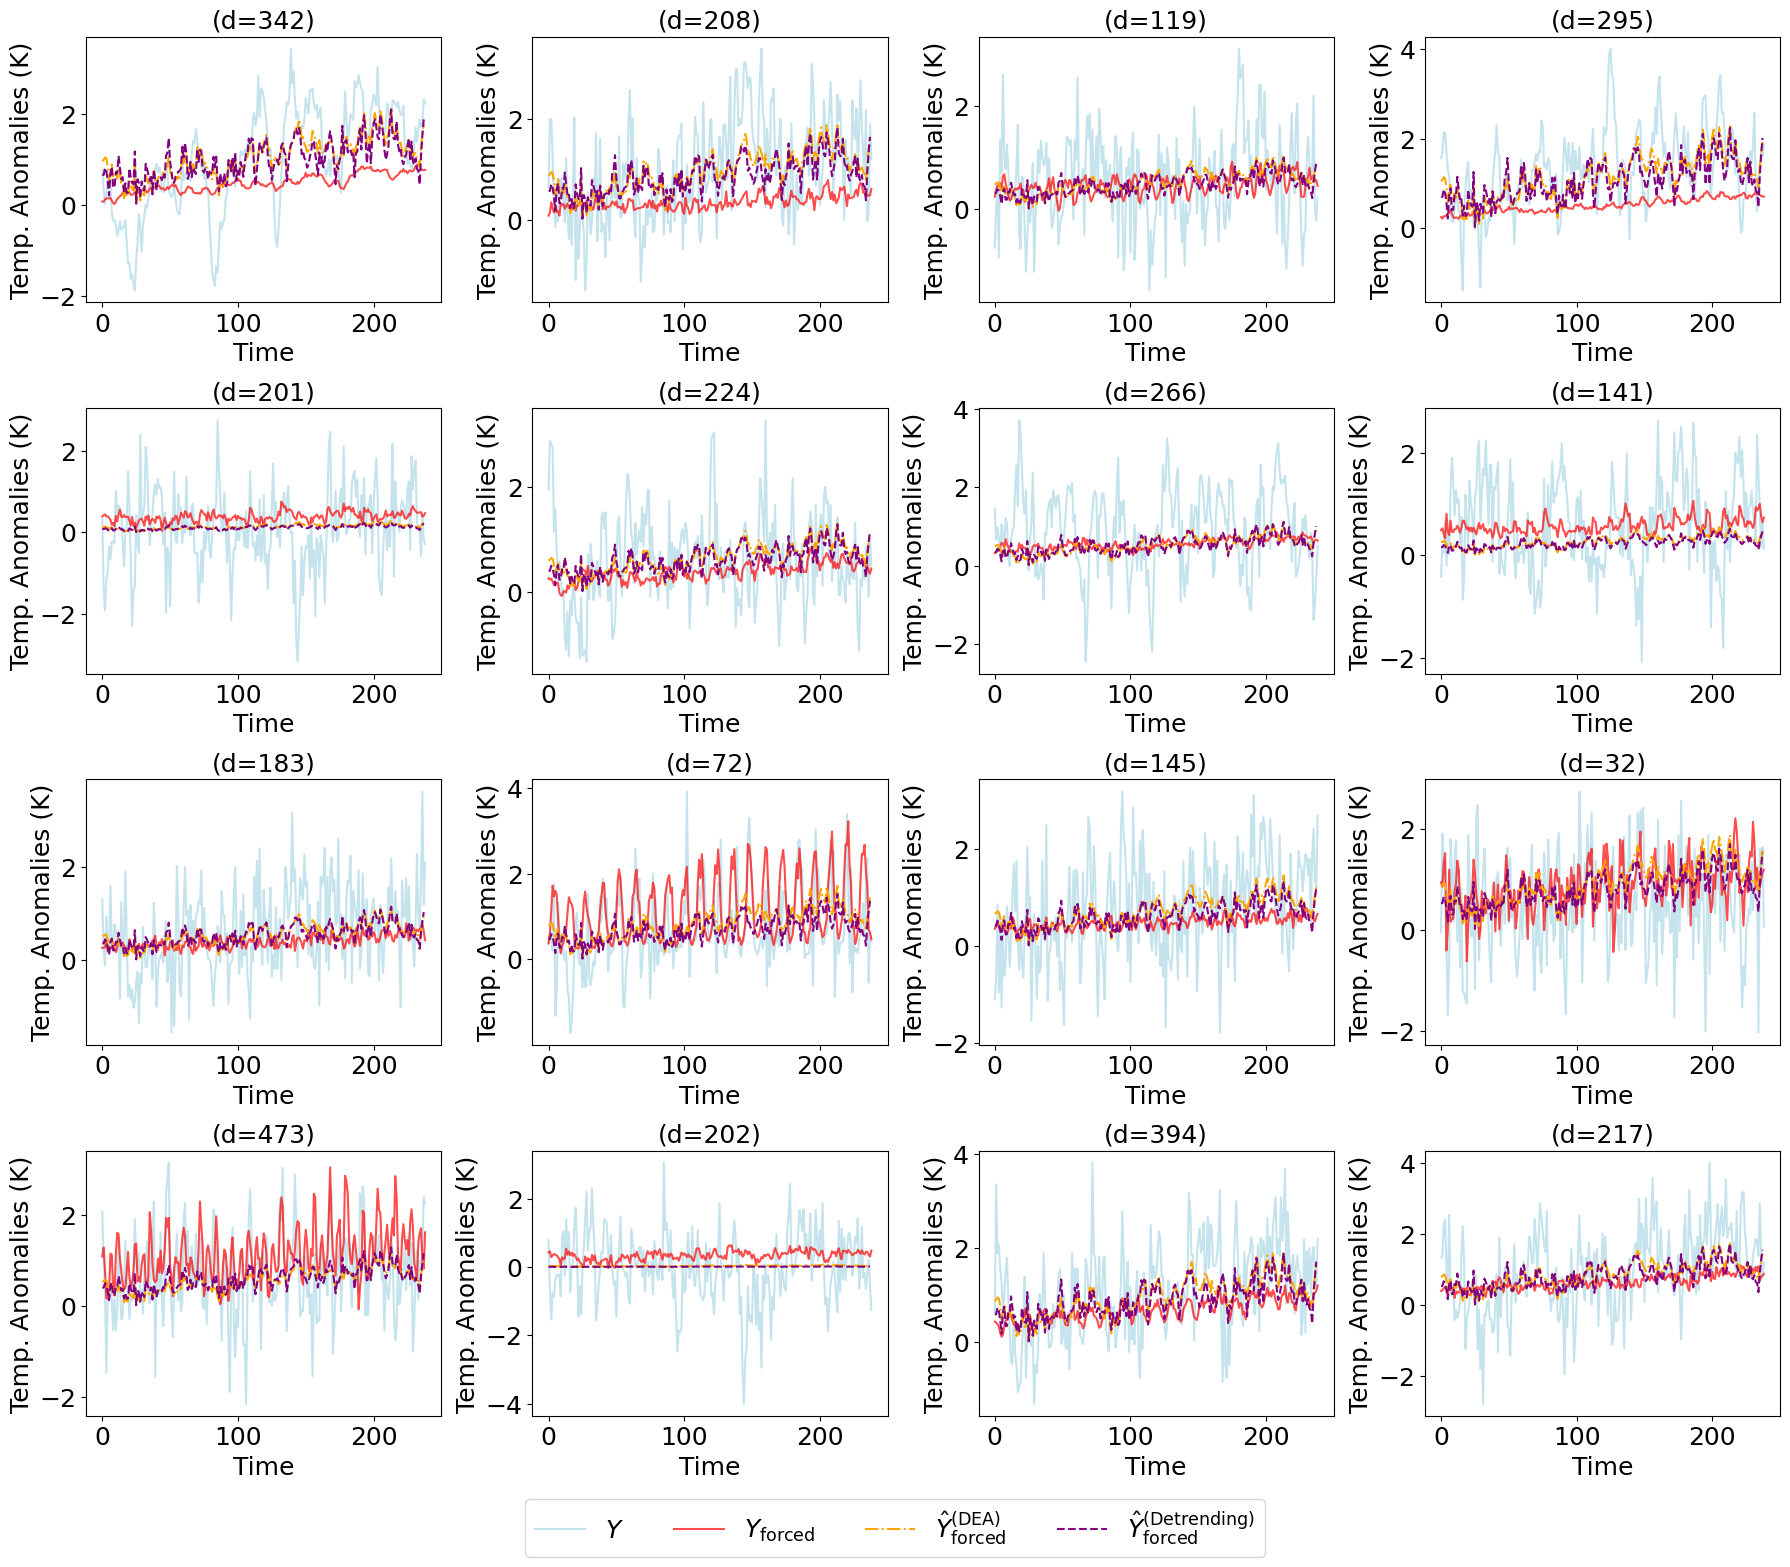

In [11]:
# Create a grid of plots
fig, axes = plt.subplots(4, 4, figsize=(18, 15))

# Randomly select 25 indices between 0 and 49
random_indices = np.random.choice(np.arange(0, 500), size=16, replace=False)

flag = 1
# Loop through the 5x5 grid and plot
for idx, ax in enumerate(axes.flat):
    if flag:
        i = random_indices[idx]  # Get the index for this subplot
        
        ax.plot(Y[start:end, i], label='$Y$', alpha=0.7, color='lightblue')
        ax.plot(forced[start:end, i], label='$Y_{\\text{forced}}$', color='red', alpha=0.7)
        ax.plot(Y_forced_DEA_hat[start:end, i], label='$\hat{Y}_{\\text{forced}}^{(\\text{DEA})}$', color='orange', linestyle='-.')
        ax.plot(Y_forced_Detrending_hat[start:end, i], label='$\hat{Y}_{\\text{forced}}^{(\\text{Detrending})}$', color='purple', linestyle='--')
        
        ax.set_title('(d={})'.format(i), fontsize=18)
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel('Temp. Anomalies (K)', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)
        flag = 0
    else:
        i = random_indices[idx]  # Get the index for this subplot
        
        ax.plot(Y[start:end, i], alpha=0.7, color='lightblue')
        ax.plot(forced[start:end, i], color='red', alpha=0.7)
        ax.plot(Y_forced_DEA_hat[start:end, i], color='orange', linestyle='-.')
        ax.plot(Y_forced_Detrending_hat[start:end, i], color='purple', linestyle='--')
        
        ax.set_title('(d={})'.format(i), fontsize=18)
        ax.set_xlabel('Time', fontsize=18)
        ax.set_ylabel('Temp. Anomalies (K)', fontsize=18)
        ax.tick_params(axis='both', labelsize=18)

# Adjust the layout
plt.tight_layout()

# Add legend only once above the plots
fig.legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), fontsize=18)

plt.show()

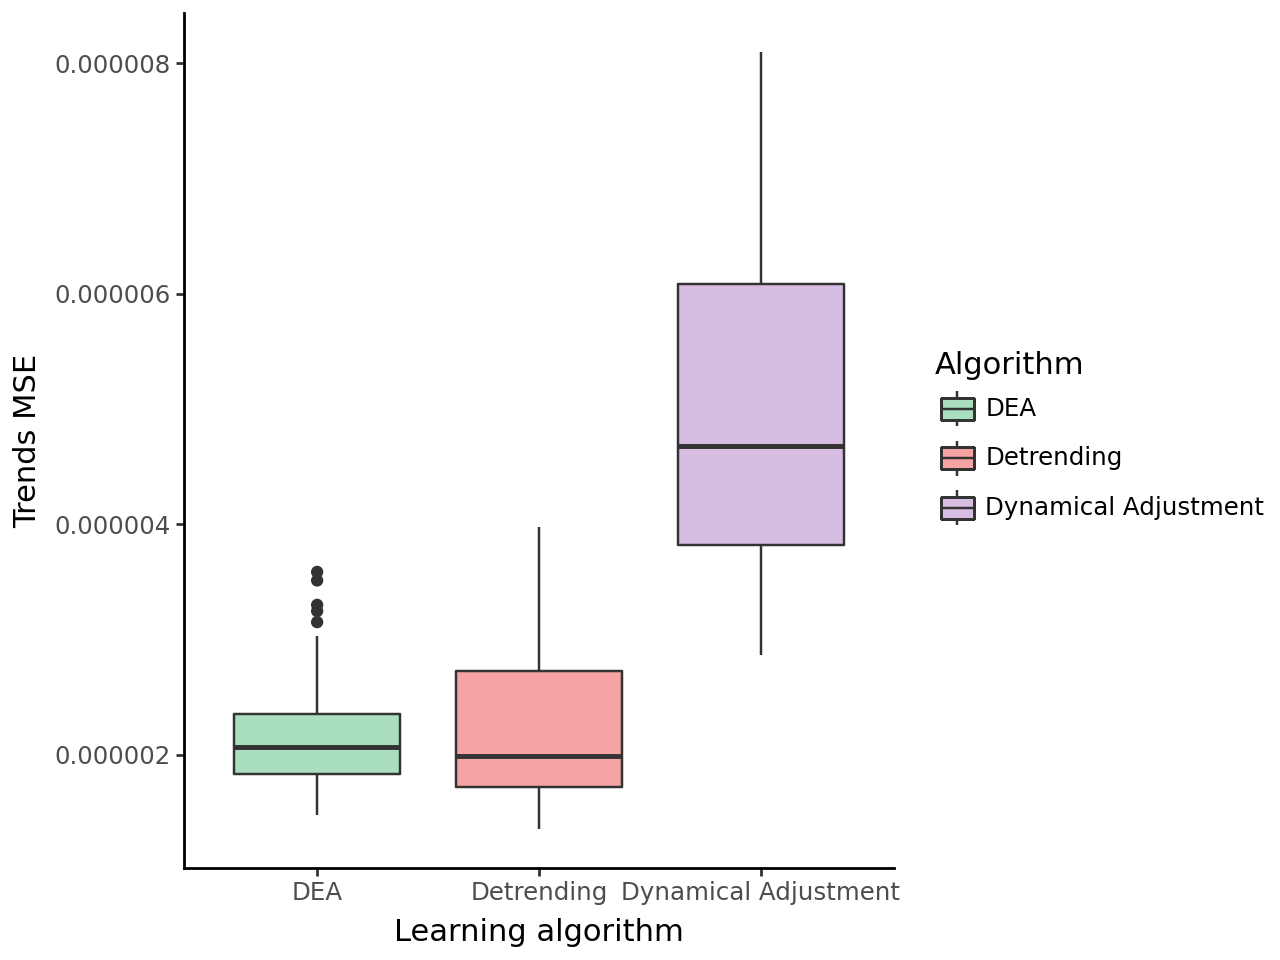

In [12]:
import pandas as pd
from plotnine import (
    ggplot, aes, geom_boxplot, labs, 
    theme_classic, scale_y_log10, scale_fill_manual
)

# Assuming MSEs is already a dictionary
df = pd.DataFrame(R2_forced)

# Melt the DataFrame to long format for ggplot
df_melted = df.melt(var_name='Algorithm', value_name='MSE')

# Define a more subdued color palette with pastel red for Detrending
colors = {
    'DEA': '#a9dfbf',  # Light Yellow
    'T_D': '#a9dfbf',  # Light Green
    'Detrending': '#f5a3a3',  # Pastel Red
    'Dynamical Adjustment': '#d7bde2',  # Pastel Red
    'T_F': '#3498db',  # More Blue (Light Blue)
    'T_S': '#d7bde2'   # Light Purple
}

# Create the boxplot using ggplot with specified colors and logarithmic Y-axis
plot = (
    ggplot(df_melted, aes(x='Algorithm', y='MSE', fill='Algorithm')) +
    geom_boxplot() +
    labs(x='Learning algorithm', y='Trends MSE') +
    # scale_y_log10() +  # Set Y-axis to logarithmic scale
    scale_fill_manual(values=colors) +  # Apply the specified subdued colors
    theme_classic()  # Optional: use a clean minimal theme
)

plot.show()

In [13]:
coefs_true_internal_list = np.array(coefs_true_internal_list)

In [14]:
errors_maps = {algo: coefs_true_internal_list - np.array(COEFs_internal[algo]) for algo in algorithms}

/tmp/ipykernel_2250/2790102124.py:164: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


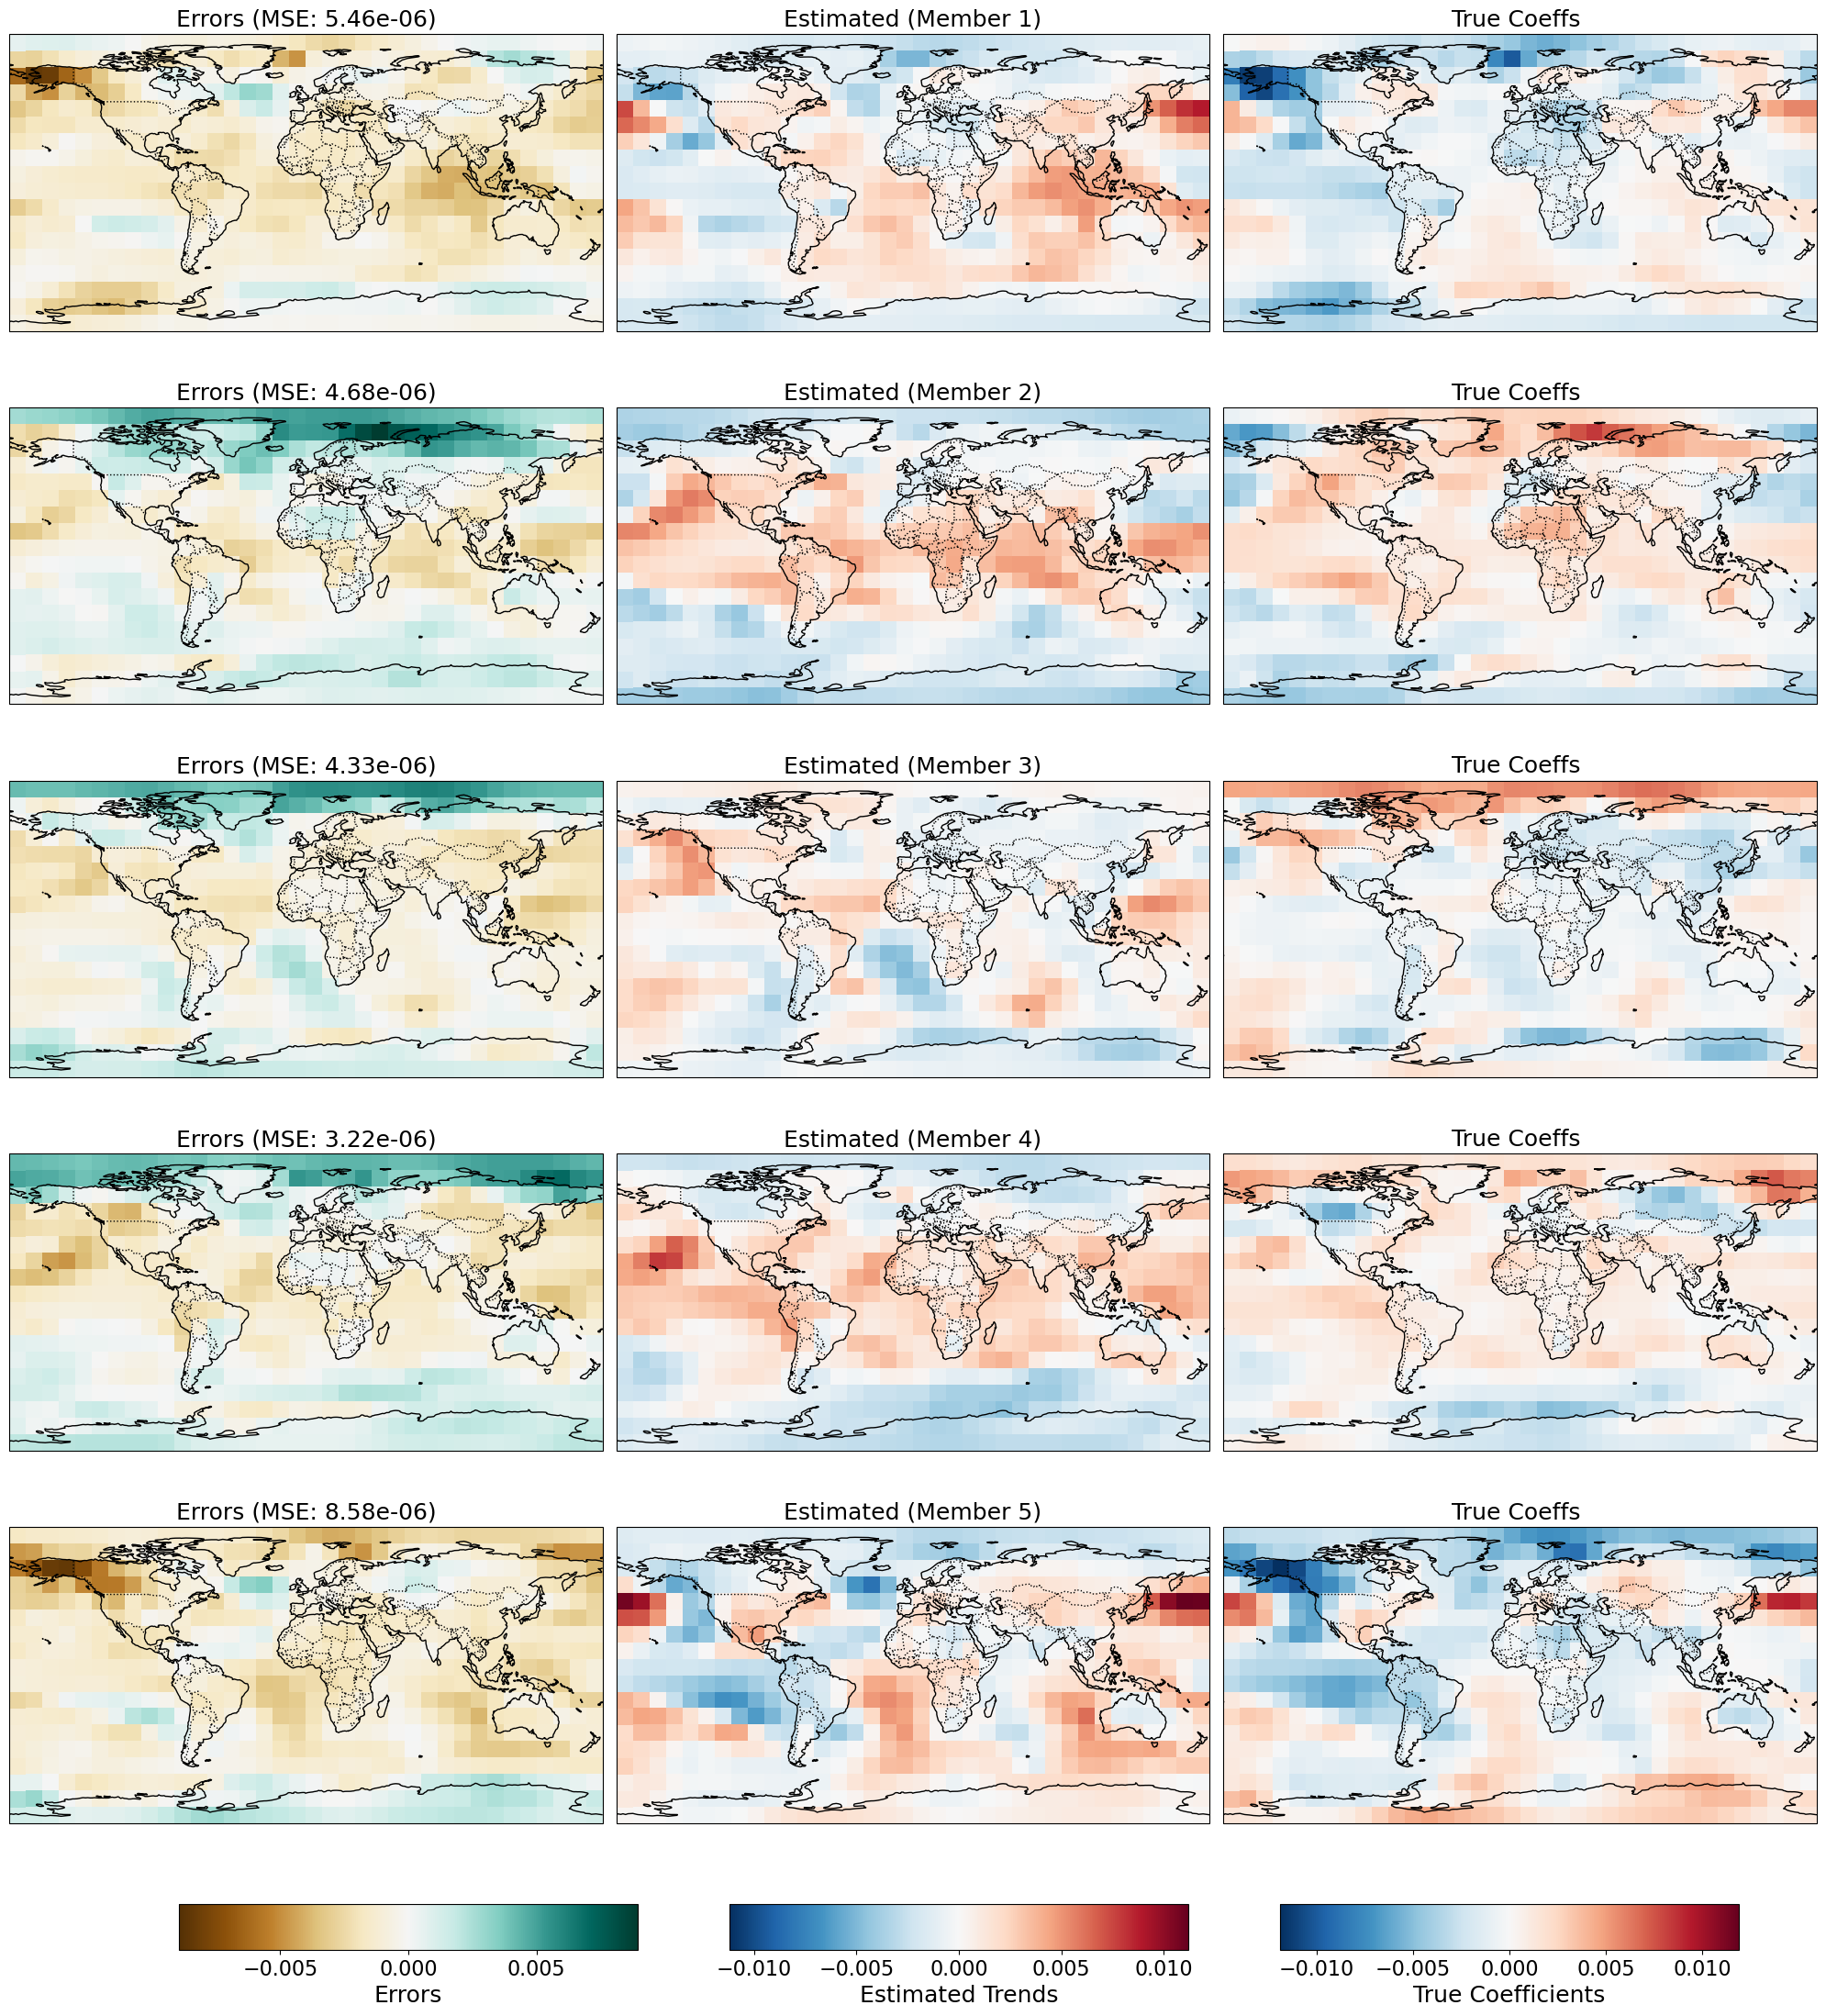

In [15]:
plot_coefficients_full(errors_maps['DEA'][:5], COEFs_internal['DEA'][:5], coefs_true_internal_list[:5], anomalies_coarsen.lon.data, anomalies_coarsen.lat.data)

In [16]:
lr = LinearRegression()
lr.fit(Z, Y)
Y_rec_reg = Y - lr.predict(Z)

In [17]:
reg_idx = np.append(np.ones(X.shape[1]), 0)
lr = PartialRidgeCV(alphas=np.logspace(1, 6, 20), reg_idx=reg_idx, n_cv=5)
# X_pca = PCA(n_components=100).fit_transform(X)
lr.fit(np.hstack((X, Z)), Y)
B = lr.coef_[-1, :, None]
B_perp = null_space(B.T)

Y_rec = Y @ B_perp @ np.linalg.inv(B_perp.T @ B_perp) @ B_perp.T

NameError: name 'Y_dynamical' is not defined

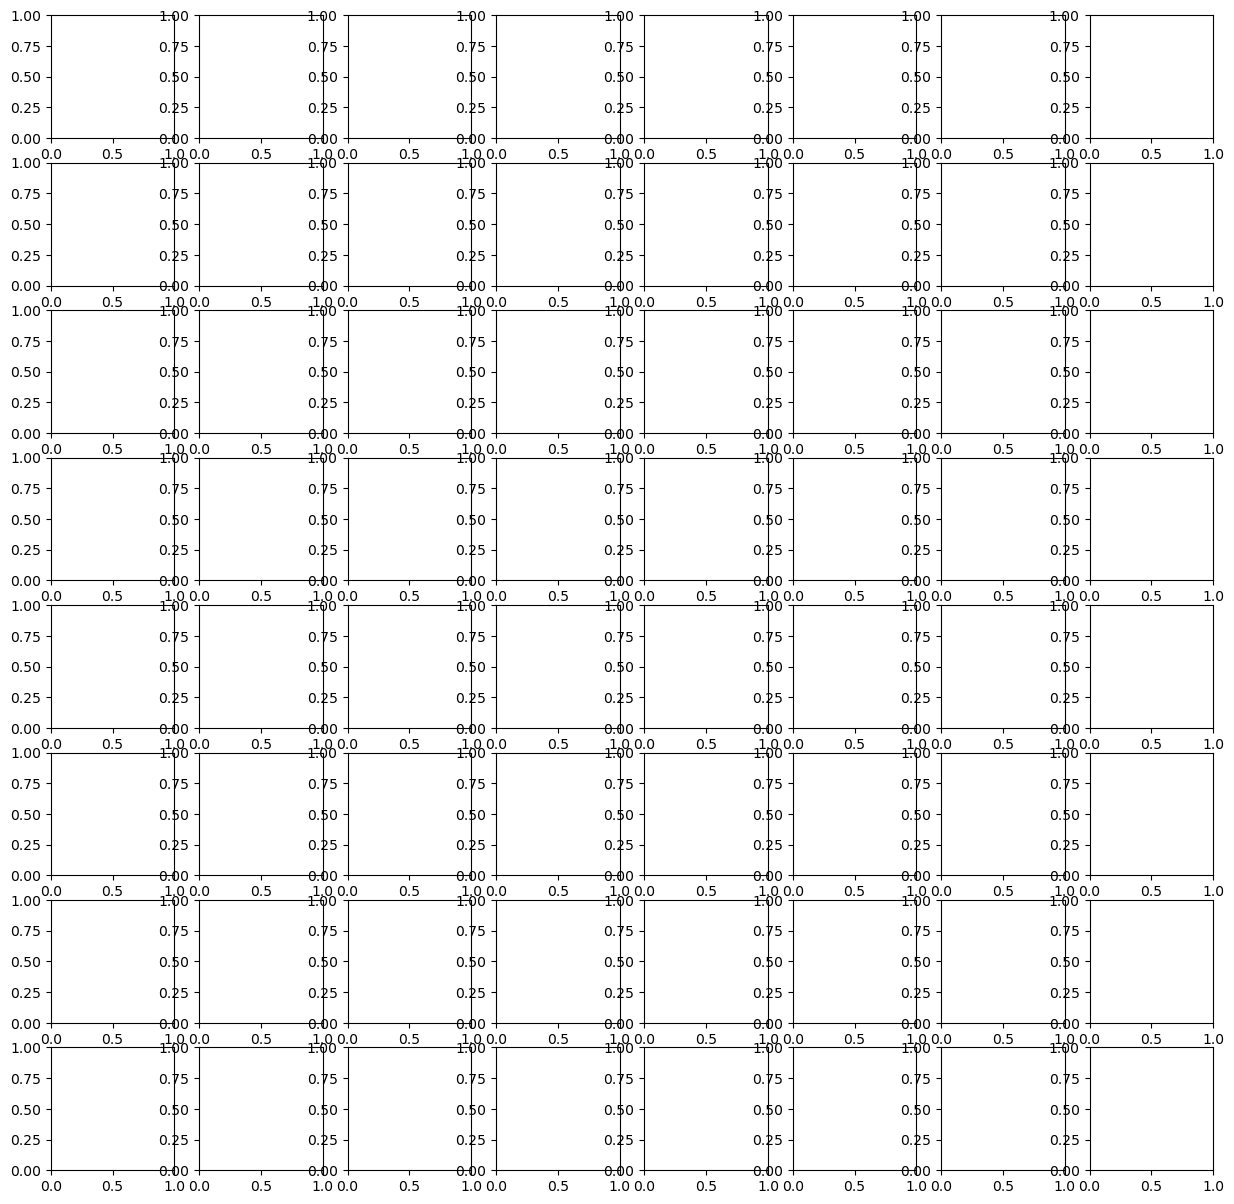

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Number of plots
n_rows, n_cols = 8, 8  
n_plots = n_rows * n_cols  

# Randomly select 25 indices
# np.random.seed(42)  # For reproducibility
random_indices = np.random.choice(Y.shape[1], n_plots, replace=False)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Loop through each subplot and fit Gaussians
for ax, idx in zip(axes.flat, random_indices):
    # Extract data for current index
    data_Y = Y[-120:-60, idx]
    data_Y_rec = Y_rec[-120:-60, idx]
    data_Y_rec_reg = Y_rec_reg[-120:-60, idx]
    data_Y_dynamical = Y_dynamical[-120:-60, idx]

    # Fit Gaussian distributions
    mu_Y, sigma_Y = norm.fit(data_Y)
    mu_Y_rec, sigma_Y_rec = norm.fit(data_Y_rec)
    mu_Y_rec_reg, sigma_Y_rec_reg = norm.fit(data_Y_rec_reg)
    mu_Y_dynamical, sigma_Y_dynamical = norm.fit(data_Y_dynamical)

    # Generate x values
    x = np.linspace(
        min(data_Y.min(), data_Y_rec.min(), data_Y_rec_reg.min(), data_Y_dynamical.min()), 
        max(data_Y.max(), data_Y_rec.max(), data_Y_rec_reg.max(), data_Y_dynamical.max()), 
        200
    )

    # Compute Gaussian PDFs
    pdf_Y = norm.pdf(x, mu_Y, sigma_Y)
    pdf_Y_rec = norm.pdf(x, mu_Y_rec, sigma_Y_rec)
    pdf_Y_rec_reg = norm.pdf(x, mu_Y_rec_reg, sigma_Y_rec_reg)
    pdf_Y_dynamical = norm.pdf(x, mu_Y_dynamical, sigma_Y_dynamical)

    # Plot the fitted Gaussians
    ax.plot(x, pdf_Y, label="Y", linewidth=2)
    ax.plot(x, pdf_Y_rec, label="Y_rec", linewidth=2, alpha=0.5)
    ax.plot(x, pdf_Y_rec_reg, label="Y_rec_reg", linewidth=2, color='red')
    ax.plot(x, pdf_Y_dynamical, label="Y_dynamical", linewidth=2, color='black', linestyle='-.')

    # Fill the curves
    ax.fill_between(x, pdf_Y, alpha=0.3)
    ax.fill_between(x, pdf_Y_rec, alpha=0.3)

    # Set title
    ax.set_title(f"Index {idx}")

# Adjust layout to make space for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust space at the bottom for legend

# Create a single legend below the subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

plt.show()


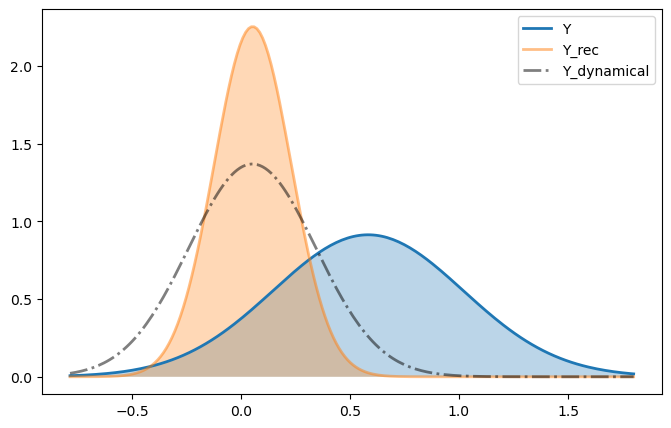

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# Compute the means across the last 120 timesteps
data_Y = Y[-480:, :].mean(axis=1)
data_Y_rec = Y_rec[-480:, :].mean(axis=1)
data_Y_dynamical = Y_dynamical[-480:, :].mean(axis=1)

# Fit Gaussian distributions
mu_Y, sigma_Y = norm.fit(data_Y)
mu_Y_rec, sigma_Y_rec = norm.fit(data_Y_rec)
mu_Y_dynamical, sigma_Y_dynamical = norm.fit(data_Y_dynamical)

# Generate values for the PDF
x = np.linspace(
    min(data_Y.min(), data_Y_rec.min(), data_Y_dynamical.min()), 
    max(data_Y.max(), data_Y_rec.max(), data_Y_dynamical.max()), 
    200
)

# Compute Gaussian PDFs
pdf_Y = norm.pdf(x, mu_Y, sigma_Y)
pdf_Y_rec = norm.pdf(x, mu_Y_rec, sigma_Y_rec)
pdf_Y_dynamical = norm.pdf(x, mu_Y_dynamical, sigma_Y_dynamical)

# Plot the fitted Gaussians
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_Y, label="Y", linewidth=2)
plt.plot(x, pdf_Y_rec, label="Y_rec", linewidth=2, alpha=0.5)
plt.plot(x, pdf_Y_dynamical, label="Y_dynamical", linewidth=2, alpha=0.5, color='black', linestyle='-.')

# Fill the curves
plt.fill_between(x, pdf_Y, alpha=0.3)
plt.fill_between(x, pdf_Y_rec, alpha=0.3)
# plt.fill_between(x, pdf_Y_dynamical, alpha=0.2, color='black')

plt.legend()
plt.show()
